<a href="https://colab.research.google.com/github/clutchkingasiimov/ABSA-/blob/main/NLP_ABSA_CNN%2BGlove_YZ.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchtext.legacy import data

In [ ]:
# set random seed
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

# Load data

In [ ]:
def load_data(path):
  df = pd.read_csv(path, delimiter='\t', header=None)
  df = df.rename(columns={
    0:'polarity',
    1:'aspect_cat',
    2:'target_term',
    3:'char_offset',
    4:'sentence'
})
  return df

In [ ]:
train = load_data('/content/drive/MyDrive/Colab Notebooks/M2_NLP/exercise2/traindata.csv')
val = load_data('/content/drive/MyDrive/Colab Notebooks/M2_NLP/exercise2/devdata.csv')

# Prepare data

## TextProcessor

In [ ]:
import string
from typing import Text
import re
import nltk
import spacy 
nltk.download('punkt')
nltk.download('stopwords')

from nltk.corpus import stopwords
import sklearn 


class TextProcessor:

    def __init__(self,text):
        self.text = text
        self.stopwords = stopwords.words('english')
        #Keeping the special characters, we re-format the punctuation
        self.special_chars = re.compile('[{}]'.format(re.escape(string.punctuation)))
        self.nlp = spacy.load("en_core_web_sm")
        self.processed_text = []

    def _iterator(self):
        for text in self.text:
            yield text

    def Preprocess_Text(self):
        for text in self._iterator():
            #Remove numbers from the string 
            cleaned_text = re.sub(r'\d+', '', text)

            #Token creation & Lemmatization
            doc = self.nlp(cleaned_text)
            tokens = [token.lemma_ for token in doc]
            tokens = [token.strip().lower() for token in tokens]

            #Stopword & Punctuation Removal 
            cleaned_tokens = [token for token in tokens if token not in self.stopwords]
            token_filters = filter(None,[self.special_chars.sub(' ', token) for token in cleaned_tokens])
            new_text = ' '.join(token_filters)

            #Whitespace removal between pre-existing punctuations & stopwords 
            new_text = " ".join(new_text.split())
            self.processed_text.append(new_text)
        return self.processed_text

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Preprocess data

In [ ]:
def preprocess(df):
  tp = TextProcessor(df['sentence'])
  df['sentence'] = tp.Preprocess_Text()
  df['inputs'] = df['aspect_cat'] + " " + \
                  df['target_term'] + " " + \
                  df['sentence']

  return df[['polarity', 'inputs']] 


In [ ]:
train_cleaned = preprocess(train)
val_cleaned = preprocess(val)

In [ ]:
train_cleaned

,polarity,inputs
0,positive,AMBIENCE#GENERAL seating short sweet – seating...
1,positive,AMBIENCE#GENERAL trattoria quaint romantic tra...
2,positive,FOOD#QUALITY food different beer offer thier g...
3,negative,SERVICE#GENERAL STAFF staff fired
4,positive,FOOD#STYLE_OPTIONS menu menu look great waiter...
...,...,...
1498,positive,DRINKS#QUALITY expresso one pron actually like...
1499,negative,SERVICE#GENERAL waitress hostess waitress incr...
1500,positive,RESTAURANT#PRICES place little place cute inte...
1501,positive,RESTAURANT#GENERAL restaurant nice family trad...


## GloVe embeddings

In [ ]:
TEXT = data.Field(tokenize = 'spacy', 
                  tokenizer_language = 'en_core_web_sm',
                  batch_first = True)
LABEL = data.LabelField(dtype = torch.float)

In [ ]:
class DataFrameDataset(data.Dataset):
  '''
  credit: https://gist.github.com/lextoumbourou/8f90313cbc3598ffbabeeaa1741a11c8
  '''

  def __init__(self, df, text_field, label_field, is_test=False, **kwargs):
      fields = [('text', text_field), ('label', label_field)]
      examples = []
      for i, row in df.iterrows():
          label = row.polarity if not is_test else None
          text = row.inputs
          examples.append(data.Example.fromlist([text, label], fields))

      super().__init__(examples, fields, **kwargs)

  @staticmethod
  def sort_key(ex):
      return len(ex.text)

  @classmethod
  def splits(cls, text_field, label_field, train_df, val_df=None, test_df=None, **kwargs):
      train_data, val_data, test_data = (None, None, None)

      if train_df is not None:
          train_data = cls(train_df.copy(), text_field, label_field, **kwargs)
      if val_df is not None:
          val_data = cls(val_df.copy(), text_field, label_field, **kwargs)
      if test_df is not None:
          test_data = cls(test_df.copy(), text_field, label_field, True, **kwargs)

      return tuple(d for d in (train_data, val_data, test_data) if d is not None)

In [ ]:
train_ds, val_ds = DataFrameDataset.splits(
  text_field=TEXT, label_field=LABEL, 
  train_df=train_cleaned, val_df=val_cleaned)

In [ ]:
MAX_VOCAB_SIZE = 25_000

TEXT.build_vocab(train_ds, 
                 max_size = MAX_VOCAB_SIZE, 
                 vectors = "glove.6B.100d", 
                 unk_init = torch.Tensor.normal_)

LABEL.build_vocab(train_ds)

.vector_cache/glove.6B.zip: 862MB [02:42, 5.32MB/s]                           
100%|█████████▉| 399999/400000 [00:15<00:00, 25076.24it/s]


In [ ]:
len(TEXT.vocab)

2385

In [ ]:
print(LABEL.vocab.stoi)

defaultdict(None, {'positive': 0, 'negative': 1, 'neutral': 2})


## Build iterators

In [ ]:
BATCH_SIZE = 5

train_iterator, val_iterator = data.BucketIterator.splits(
    (train_ds, val_ds), 
    batch_size = BATCH_SIZE, 
    device = device)

# Build Model

## CNN_Glove

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout, pad_idx):
        
        super().__init__()
                
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)
        
        self.convs = nn.ModuleList([
                                    nn.Conv2d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = (fs, embedding_dim)) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
                
        #text = [batch size, sent len]
        
        embedded = self.embedding(text)
                
        #embedded = [batch size, sent len, emb dim]
        
        embedded = embedded.unsqueeze(1)
        
        #embedded = [batch size, 1, sent len, emb dim]
        
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
            
        #conved_n = [batch size, n_filters, sent len - filter_sizes[n] + 1]
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        #pooled_n = [batch size, n_filters]
        
        cat = self.dropout(torch.cat(pooled, dim = 1))

        #cat = [batch size, n_filters * len(filter_sizes)]
            
        return self.fc(cat)

# Train Model

## utils

In [ ]:
def accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    """
    # #round predictions to the closest integer
    top_pred = preds.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [ ]:
def train_model(model, iterator, optimizer, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch in iterator:
        
        optimizer.zero_grad()
        
        predictions = model(batch.text).squeeze(1)
        
        loss = criterion(predictions, batch.label.long())
        
        acc = accuracy(predictions, batch.label)
        
        loss.backward()
        
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    
      
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
def evaluate_model(model, iterator, criterion):
    
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch in iterator:

            predictions = model(batch.text).squeeze(1)
            
            loss = criterion(predictions, batch.label.long())
            
            acc = accuracy(predictions, batch.label)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [ ]:
import matplotlib.pyplot as plt

def plot_acc(train_acc, val_acc, nb_epochs):
    plt.plot(list(range(nb_epochs+1))[1:], train_acc)
    plt.plot(list(range(nb_epochs+1))[1:], val_acc)
    plt.legend(['train', 'val'])
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()
    # plt.savefig('{}/chart.png'.format(save_folder))

## with GloVe embeddings

In [ ]:
INPUT_DIM = len(TEXT.vocab)
EMBEDDING_DIM = 100
N_FILTERS = 200
FILTER_SIZES = [1,2,3,4]
OUTPUT_DIM = 3 # 3 labels
DROPOUT = 0.15
PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]

model = CNN(INPUT_DIM, EMBEDDING_DIM, N_FILTERS, FILTER_SIZES, OUTPUT_DIM, DROPOUT, PAD_IDX)

In [ ]:
# load pre-trained embeddings

pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

tensor([[ 1.9269,  1.4873,  0.9007,  ...,  0.1233,  0.3499,  0.6173],
        [ 0.7262,  0.0912, -0.3891,  ...,  0.0821,  0.4440, -0.7240],
        [ 0.1134,  0.0624,  0.6683,  ...,  0.4773,  0.0420,  0.0243],
        ...,
        [ 0.1238,  0.0467,  0.1646,  ..., -0.1151,  0.2209, -0.4480],
        [ 0.1164,  0.1429, -0.1048,  ...,  0.4136, -0.1188,  0.0844],
        [ 0.4149, -0.3073, -0.3590,  ..., -0.8834,  0.5939,  0.1043]])

In [ ]:
# zero the initial weights of the unknown and padding tokens

UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]

model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [ ]:
LR = 1e-4
optimizer = optim.Adam(model.parameters(), lr = LR)

criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

Epoch: 01 | Epoch Time: 0m 3s
	Train Loss: 0.708 | Train Acc: 70.03%
	 Val. Loss: 0.674 |  Val. Acc: 70.53%
Epoch: 02 | Epoch Time: 0m 4s
	Train Loss: 0.602 | Train Acc: 75.64%
	 Val. Loss: 0.631 |  Val. Acc: 72.63%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.534 | Train Acc: 78.60%
	 Val. Loss: 0.600 |  Val. Acc: 75.00%
Epoch: 04 | Epoch Time: 0m 2s
	Train Loss: 0.465 | Train Acc: 83.06%
	 Val. Loss: 0.570 |  Val. Acc: 77.37%
Epoch: 05 | Epoch Time: 0m 2s
	Train Loss: 0.407 | Train Acc: 86.64%
	 Val. Loss: 0.551 |  Val. Acc: 80.00%
Epoch: 06 | Epoch Time: 0m 2s
	Train Loss: 0.361 | Train Acc: 87.80%
	 Val. Loss: 0.556 |  Val. Acc: 78.68%
Epoch: 07 | Epoch Time: 0m 2s
	Train Loss: 0.313 | Train Acc: 90.10%
	 Val. Loss: 0.542 |  Val. Acc: 79.47%
Epoch: 08 | Epoch Time: 0m 2s
	Train Loss: 0.277 | Train Acc: 91.16%
	 Val. Loss: 0.527 |  Val. Acc: 81.84%
Epoch: 09 | Epoch Time: 0m 2s
	Train Loss: 0.239 | Train Acc: 92.43%
	 Val. Loss: 0.535 |  Val. Acc: 81.32%
Epoch: 10 | Epoch Time: 0m 2

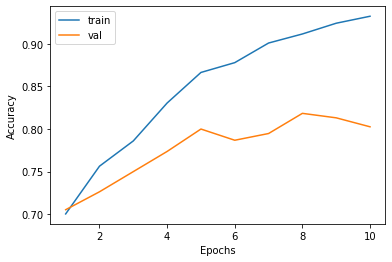

In [ ]:
N_EPOCHS = 10

best_valid_loss = float('inf')
total_train_acc = []
total_val_acc = []

for epoch in range(N_EPOCHS):

    start_time = time.time()
    
    train_loss, train_acc = train_model(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc = evaluate_model(model, val_iterator, criterion)
    
    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    total_train_acc.append(train_acc)
    total_val_acc.append(valid_acc)

    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model.pt')
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

plot_acc(total_train_acc, total_val_acc, N_EPOCHS)

In [ ]:
model.load_state_dict(torch.load('model.pt'))

test_loss, test_acc = evaluate_model(model, val_iterator, criterion)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.527 | Test Acc: 81.84%


In [ ]:
def get_predsevaluate(model, iterator):

  outputs = []
  pred_labels = []
  
  model.eval()
  
  with torch.no_grad():
  
      for batch in iterator:

        output = model(batch.text).squeeze(1)
        outputs.append(output)
      
      for batch in outputs:
        for sentence in batch:
          pred = sentence.argmax()
          pred_labels.append(pred.item())

      
  return pred_labels

In [ ]:
get_predsevaluate(model, val_iterator)
